# Training a neural network with McSnow accretion output

This script applies a DNN to the regression problem compare with Seifert and Beheng (2001)

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


### Load Tensorflow and other useful modules

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [2]:
tf.random.set_seed(1234)

### Load data from netcdf

In [3]:
import numpy as np
import xarray as xr

In [4]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

data="big_n5"
fname1=mdir+edir+'autocon_train_'+data+'.nc'
fname2=mdir+edir+'autocon_test_'+data+'.nc'
fname3=mdir+edir+'autocon_val_big_n2.nc'

ds1 = xr.open_dataset(fname1)
ds2 = xr.open_dataset(fname2)
ds2 = xr.open_dataset(fname3)

print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:     (i: 6, ii: 6, j: 7, jj: 7, k: 5, kk: 5, n: 5, nn: 5, nt: 4000)
Coordinates:
  * n           (n) int32 0 1 2 3 4
  * i           (i) int32 200 400 600 800 1000 2000
  * j           (j) int32 9 10 11 12 13 14 15
  * k           (k) int32 0 1 2 3 4
Dimensions without coordinates: ii, jj, kk, nn, nt
Data variables:
    time        (n, i, j, k, nt) float32 ...
    tau         (n, i, j, k, nt) float32 ...
    Lc          (n, i, j, k, nt) float32 ...
    Nc          (n, i, j, k, nt) float32 ...
    Zc          (n, i, j, k, nt) float32 ...
    Lr          (n, i, j, k, nt) float32 ...
    Nr          (n, i, j, k, nt) float32 ...
    Zr          (n, i, j, k, nt) float32 ...
    nu          (n, i, j, k, nt) float32 ...
    mue         (n, i, j, k, nt) float64 ...
    nue         (n, i, j, k, nt) float64 ...
    auto_num    (n, i, j, k, nt) float32 ...
    auto_mass   (n, i, j, k, nt) float32 ...
    accr_num    (n, i, j, k, nt) float32 ...
    accr_mass   (n

# Prepare data for training

In [5]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    tau  = xr.open_dataset(fname).tau.values
    acc  = xr.open_dataset(fname).accr_mass.values
    accN = xr.open_dataset(fname).accr_num.values
    Lc   = xr.open_dataset(fname).Lc.values
    Lr   = xr.open_dataset(fname).Lr.values
    Nc   = xr.open_dataset(fname).Nc.values
    Nr   = xr.open_dataset(fname).Nr.values
    nu   = xr.open_dataset(fname).nu.values
    # transform everything except nu in log space
    L_min = 1e-15
    N_min = 1e-15
    tau_min  = 1e-15
    acc_min = 1e-15
    Xc = np.log(Lc/Nc, where=Nc>N_min)
    Xr = np.log(Lr/Nr, where=Nr>N_min)  # do Xr first!
    Nc = np.log(Nc, where=Nc>N_min)
    Lc = np.log(Lc, where=Lc>L_min)
    Nr = np.log(Nr, where=Nr>N_min)
    Lr = np.log(Lr, where=Lr>L_min)
    tau = np.log(tau, where=tau>tau_min, out=np.nan*tau)    
    acc = np.log(acc, where=acc>acc_min, out=np.nan*acc)
    accN = np.log(accN, where=accN>acc_min, out=np.nan*accN)
    # put everything in a pandas dataframe    
    dataset = pd.DataFrame(np.array( [ acc.ravel(), accN.ravel(), Lc.ravel(), Lr.ravel(), Xc.ravel(), Xr.ravel(), nu.ravel(), tau.ravel() ]))
    dataset = dataset.T
    dataset.columns = ['acc','accN','Lc','Lr','Xc','Xr','nu','tau'] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [6]:
dataset_train = read_and_prepare_data(fname1)
dataset_test  = read_and_prepare_data(fname2)
dataset_val   = read_and_prepare_data(fname3)

/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/Volumes/

### Inspect the data

In [7]:
dataset_train.describe()

acc           accN             Lc             Lr  \
count  390266.000000  390266.000000  390266.000000  390266.000000   
mean      -19.820944       6.023250      -9.735505     -11.401494   
std         4.295667       4.251148       2.381932       4.875874   
min       -34.538765      -9.996480     -15.429439     -29.565296   
25%       -21.615437       4.412732     -11.660074     -13.758996   
50%       -18.946712       6.957654      -8.620265      -8.893823   
75%       -16.913187       8.833184      -7.829179      -7.894393   
max       -11.982386      14.027852      -6.215683      -6.216760   

                  Xc             Xr             nu            tau  
count  390266.000000  390266.000000  390266.000000  390266.000000  
mean      -25.974607     -17.312515       2.085209      -3.567672  
std         0.650774       3.806687       1.390925       4.855076  
min       -28.920919     -22.069162       0.000000     -23.348867  
25%       -26.412858     -20.987723       1.000000      -5.892014  
50%       -25.963396     -18.102999       2.000000      -0.899198  
75%       -25.502439     -13.829069       3.000000      -0.021771  
max       -24.881920      -9.336143       4.000000      -0.001000

In [8]:
dataset_test.describe()

acc           accN             Lc             Lr  \
count  228645.000000  228645.000000  228645.000000  228645.000000   
mean      -19.454084       6.371817      -9.447169     -11.325500   
std         4.396365       4.346577       2.328032       5.063498   
min       -34.538635      -9.888796     -15.021038     -29.615793   
25%       -21.063938       4.938974     -11.353958     -13.793944   
50%       -18.479082       7.399979      -8.219941      -8.662282   
75%       -16.333021       9.350554      -7.603813      -7.667846   
max       -12.561091      13.512413      -6.503471      -6.504506   

                  Xc             Xr             nu            tau  
count  228645.000000  228645.000000  228645.000000  228645.000000  
mean      -25.942194     -17.338531       2.046043      -3.747119  
std         0.589544       3.824919       1.107910       5.049244  
min       -28.124483     -22.068624       0.500000     -22.840141  
25%       -26.404255     -21.035391       1.500000      -6.196519  
50%       -25.919214     -18.180853       2.500000      -1.003565  
75%       -25.484699     -13.823285       3.500000      -0.023040  
max       -24.882586      -9.635016       3.500000      -0.001001

### Reduce the data

In [9]:
def reduce_data(dataset):
    idx = dataset[ dataset['tau'] > np.log(0.99) ].index
    dataset.drop(idx,inplace=True)
    return dataset

In [10]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

In [11]:
dataset_train.describe()

acc           accN             Lc             Lr  \
count  316141.000000  316141.000000  316141.000000  316141.000000   
mean      -19.684107       6.054800      -8.829428     -12.237478   
std         4.702078       4.663903       1.576173       5.057483   
min       -34.538765      -9.996480     -13.126979     -29.565296   
25%       -21.655706       4.034936      -9.675200     -15.107706   
50%       -18.261593       7.475090      -8.519812     -10.288997   
75%       -16.632055       9.170491      -7.825229      -8.533669   
max       -11.982386      14.027852      -6.215683      -6.225957   

                  Xc             Xr             nu            tau  
count  316141.000000  316141.000000  316141.000000  316141.000000  
mean      -25.854603     -18.582525       2.135731      -4.404061  
std         0.537889       3.003278       1.386996       5.043261  
min       -27.797625     -22.069162       0.000000     -23.348867  
25%       -26.322495     -21.265429       1.000000      -7.242288  
50%       -25.862318     -19.511898       2.000000      -2.416502  
75%       -25.383728     -16.188467       3.000000      -0.177707  
max       -24.881920     -10.636853       4.000000      -0.010051

In [12]:
dataset_test.describe()

acc           accN             Lc             Lr  \
count  185956.000000  185956.000000  185956.000000  185956.000000   
mean      -19.358082       6.381876      -8.556026     -12.184974   
std         4.830826       4.783397       1.502526       5.245859   
min       -34.538635      -9.888796     -12.718877     -29.615793   
25%       -21.427819       4.272240      -9.352686     -15.147145   
50%       -17.735312       8.018983      -8.113855     -10.181244   
75%       -16.031311       9.690560      -7.602155      -8.132809   
max       -12.561091      13.512413      -6.503471      -6.513580   

                  Xc             Xr            nu            tau  
count  185956.000000  185956.000000  185956.00000  185956.000000  
mean      -25.841108     -18.601168       2.07740      -4.607143  
std         0.523737       3.017207       1.10703       5.233325  
min       -27.330093     -22.068624       0.50000     -22.840141  
25%       -26.297128     -21.303157       1.50000      -7.546070  
50%       -25.858821     -19.575207       2.50000      -2.582053  
75%       -25.381053     -16.186631       3.50000      -0.189211  
max       -24.882586     -10.769567       3.50000      -0.010051

In [13]:
dataset_val.describe()

acc           accN             Lc             Lr  \
count  126347.000000  126347.000000  126347.000000  126347.000000   
mean      -19.722277       6.013494      -8.821718     -12.285093   
std         4.756928       4.714730       1.572551       5.105659   
min       -34.538105     -10.142760     -13.126989     -29.809435   
25%       -21.748417       3.948884      -9.654527     -15.189476   
50%       -18.270658       7.461864      -8.519566     -10.325713   
75%       -16.628572       9.188058      -7.825274      -8.533691   
max       -11.999689      14.027812      -6.215693      -6.225902   

                  Xc             Xr             nu            tau  
count  126347.000000  126347.000000  126347.000000  126347.000000  
mean      -25.852430     -18.604530       2.142623      -4.452001  
std         0.536549       3.003396       1.389153       5.081125  
min       -27.793121     -22.068741       0.000000     -23.593521  
25%       -26.304808     -21.293740       1.000000      -7.314804  
50%       -25.859968     -19.563856       2.000000      -2.457483  
75%       -25.383237     -16.208543       3.000000      -0.180579  
max       -24.883766     -10.337401       4.000000      -0.010051

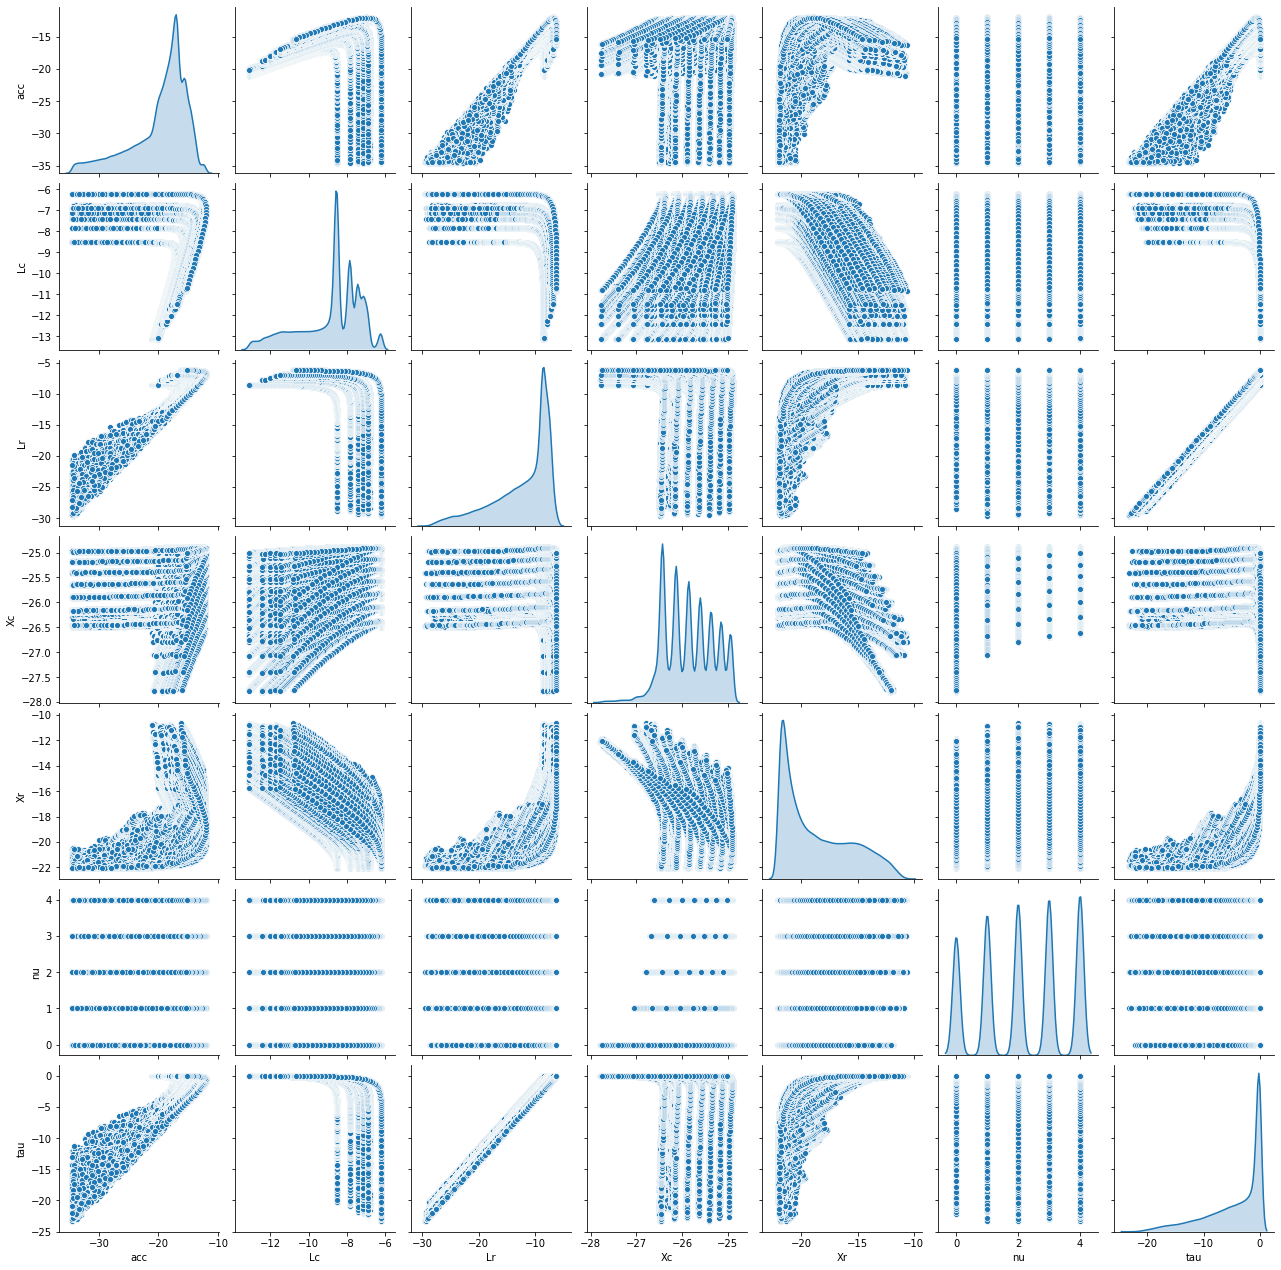

In [14]:
sns.pairplot(dataset_train[['acc','Lc','Lr','Xc','Xr','nu','tau']], diag_kind="kde")

## Separate in different dataset with selected sets of predictors

In [15]:
train_dataset0 = dataset_train.copy()
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()
train_dataset4 = dataset_train.copy()

test_dataset0 = dataset_test.copy()
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()
test_dataset4 = dataset_test.copy()

val_dataset0 = dataset_val.copy()
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()
val_dataset4 = dataset_val.copy()

In [16]:
train_dataset0 = train_dataset0.drop(['Xc','Xr','nu','tau'], axis=1)
train_dataset1 = train_dataset1.drop(['Xr','nu','tau'], axis=1)
train_dataset2 = train_dataset2.drop(['nu','tau'], axis=1)
train_dataset3 = train_dataset3.drop("tau", axis=1)
train_dataset4 = train_dataset4.drop(['Xc','Xr','nu'], axis=1)

In [17]:
test_dataset0 = test_dataset0.drop(['Xc','Xr','nu','tau'], axis=1)
test_dataset1 = test_dataset1.drop(['Xr','nu','tau'], axis=1)
test_dataset2 = test_dataset2.drop(['nu','tau'], axis=1)
test_dataset3 = test_dataset3.drop('tau', axis=1)
test_dataset4 = test_dataset4.drop(['Xc','Xr','nu'], axis=1)

In [18]:
val_dataset0 = val_dataset0.drop(['Xc','Xr','nu','tau'], axis=1)
val_dataset1 = val_dataset1.drop(['Xr','nu','tau'], axis=1)
val_dataset2 = val_dataset2.drop(['nu','tau'], axis=1)
val_dataset3 = val_dataset3.drop('tau', axis=1)
val_dataset4 = val_dataset4.drop(['Xc','Xr','nu'], axis=1)

In [19]:
train_stats0 = train_dataset0.describe()
train_stats0.pop("acc")
train_stats0.pop("accN")
train_stats0 = train_stats0.transpose()
train_stats0

count       mean       std        min        25%        50%       75%  \
Lc  316141.0  -8.829428  1.576173 -13.126979  -9.675200  -8.519812 -7.825229   
Lr  316141.0 -12.237478  5.057483 -29.565296 -15.107706 -10.288997 -8.533669   

         max  
Lc -6.215683  
Lr -6.225957

In [20]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("acc")
train_stats1.pop("accN")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%        75%  \
Lc  316141.0  -8.829428  1.576173 -13.126979  -9.675200  -8.519812  -7.825229   
Lr  316141.0 -12.237478  5.057483 -29.565296 -15.107706 -10.288997  -8.533669   
Xc  316141.0 -25.854603  0.537889 -27.797625 -26.322495 -25.862318 -25.383728   

          max  
Lc  -6.215683  
Lr  -6.225957  
Xc -24.881920

In [21]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("acc")
train_stats2.pop("accN")
train_stats2 = train_stats2.transpose()
train_stats2

count       mean       std        min        25%        50%        75%  \
Lc  316141.0  -8.829428  1.576173 -13.126979  -9.675200  -8.519812  -7.825229   
Lr  316141.0 -12.237478  5.057483 -29.565296 -15.107706 -10.288997  -8.533669   
Xc  316141.0 -25.854603  0.537889 -27.797625 -26.322495 -25.862318 -25.383728   
Xr  316141.0 -18.582525  3.003278 -22.069162 -21.265429 -19.511898 -16.188467   

          max  
Lc  -6.215683  
Lr  -6.225957  
Xc -24.881920  
Xr -10.636853

In [22]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("acc")
train_stats3.pop("accN")
train_stats3 = train_stats3.transpose()
train_stats3

count       mean       std        min        25%        50%        75%  \
Lc  316141.0  -8.829428  1.576173 -13.126979  -9.675200  -8.519812  -7.825229   
Lr  316141.0 -12.237478  5.057483 -29.565296 -15.107706 -10.288997  -8.533669   
Xc  316141.0 -25.854603  0.537889 -27.797625 -26.322495 -25.862318 -25.383728   
Xr  316141.0 -18.582525  3.003278 -22.069162 -21.265429 -19.511898 -16.188467   
nu  316141.0   2.135731  1.386996   0.000000   1.000000   2.000000   3.000000   

          max  
Lc  -6.215683  
Lr  -6.225957  
Xc -24.881920  
Xr -10.636853  
nu   4.000000

In [23]:
train_stats4 = train_dataset4.describe()
train_stats4.pop("acc")
train_stats4.pop("accN")
train_stats4 = train_stats4.transpose()
train_stats4

count       mean       std        min        25%        50%       75%  \
Lc   316141.0  -8.829428  1.576173 -13.126979  -9.675200  -8.519812 -7.825229   
Lr   316141.0 -12.237478  5.057483 -29.565296 -15.107706 -10.288997 -8.533669   
tau  316141.0  -4.404061  5.043261 -23.348867  -7.242288  -2.416502 -0.177707   

          max  
Lc  -6.215683  
Lr  -6.225957  
tau -0.010051

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [24]:
train_labels0 = train_dataset0[['acc','accN']].copy()
train_labels1 = train_dataset1[['acc','accN']].copy()
train_labels2 = train_dataset2[['acc','accN']].copy()
train_labels3 = train_dataset3[['acc','accN']].copy()
train_labels4 = train_dataset4[['acc','accN']].copy()

train_dataset0.drop(['acc','accN'], axis=1, inplace=True)
train_dataset1.drop(['acc','accN'], axis=1, inplace=True)
train_dataset2.drop(['acc','accN'], axis=1, inplace=True)
train_dataset3.drop(['acc','accN'], axis=1, inplace=True)
train_dataset4.drop(['acc','accN'], axis=1, inplace=True)

test_labels0 = test_dataset0[['acc','accN']].copy()
test_labels1 = test_dataset1[['acc','accN']].copy()
test_labels2 = test_dataset2[['acc','accN']].copy()
test_labels3 = test_dataset3[['acc','accN']].copy()
test_labels4 = test_dataset4[['acc','accN']].copy()

test_dataset0.drop(['acc','accN'], axis=1, inplace=True)
test_dataset1.drop(['acc','accN'], axis=1, inplace=True)
test_dataset2.drop(['acc','accN'], axis=1, inplace=True)
test_dataset3.drop(['acc','accN'], axis=1, inplace=True)
test_dataset4.drop(['acc','accN'], axis=1, inplace=True)

In [25]:
val_labels0 = val_dataset0[['acc','accN']].copy()
val_labels1 = val_dataset1[['acc','accN']].copy()
val_labels2 = val_dataset2[['acc','accN']].copy()
val_labels3 = val_dataset3[['acc','accN']].copy()
val_labels4 = val_dataset4[['acc','accN']].copy()

val_dataset0.drop(['acc','accN'], axis=1, inplace=True)
val_dataset1.drop(['acc','accN'], axis=1, inplace=True)
val_dataset2.drop(['acc','accN'], axis=1, inplace=True)
val_dataset3.drop(['acc','accN'], axis=1, inplace=True)
val_dataset4.drop(['acc','accN'], axis=1, inplace=True)

### Normalize the data

In [26]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data0 = norm(train_dataset0,train_stats0)
normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)
normed_train_data4 = norm(train_dataset4,train_stats4)

normed_test_data0 = norm(test_dataset0,train_stats0)
normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)
normed_test_data4 = norm(test_dataset4,train_stats4)

normed_val_data0 = norm(val_dataset0,train_stats0)
normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)
normed_val_data3 = norm(val_dataset3,train_stats3)
normed_val_data4 = norm(val_dataset4,train_stats4)

In [27]:
normed_train_stats0 = normed_train_data0.describe()
normed_train_stats0 = normed_train_stats0.transpose()
normed_train_stats0

count      mean       std       min       25%       50%       75%  \
Lc  316141.0  0.000289  0.999911 -2.726574 -0.536599  0.196435  0.637112   
Lr  316141.0 -0.000060  1.000072 -3.426174 -0.567521  0.385267  0.732343   

         max  
Lc  1.658286  
Lr  1.188639

In [28]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count      mean       std       min       25%       50%       75%  \
Lc  316141.0  0.000289  0.999911 -2.726574 -0.536599  0.196435  0.637112   
Lr  316141.0 -0.000060  1.000072 -3.426174 -0.567521  0.385267  0.732343   
Xc  316141.0  0.005338  1.000069 -3.612307 -0.869866 -0.014344  0.875412   

         max  
Lc  1.658286  
Lr  1.188639  
Xc  1.808332

In [29]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count      mean       std       min       25%       50%       75%  \
Lc  316141.0  0.000289  0.999911 -2.726574 -0.536599  0.196435  0.637112   
Lr  316141.0 -0.000060  1.000072 -3.426174 -0.567521  0.385267  0.732343   
Xc  316141.0  0.005338  1.000069 -3.612307 -0.869866 -0.014344  0.875412   
Xr  316141.0  0.000525  1.000032 -1.160944 -0.893325 -0.309453  0.797149   

         max  
Lc  1.658286  
Lr  1.188639  
Xc  1.808332  
Xr  2.645667

In [30]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean       std       min       25%       50%       75%  \
Lc  316141.0  2.888669e-04  0.999911 -2.726574 -0.536599  0.196435  0.637112   
Lr  316141.0 -6.008369e-05  1.000072 -3.426174 -0.567521  0.385267  0.732343   
Xc  316141.0  5.338306e-03  1.000069 -3.612307 -0.869866 -0.014344  0.875412   
Xr  316141.0  5.249968e-04  1.000032 -1.160944 -0.893325 -0.309453  0.797149   
nu  316141.0  5.113517e-08  0.999693 -1.539825 -0.818842 -0.097859  0.623123   

         max  
Lc  1.658286  
Lr  1.188639  
Xc  1.808332  
Xr  2.645667  
nu  1.344106

In [31]:
normed_train_stats4 = normed_train_data4.describe()
normed_train_stats4 = normed_train_stats4.transpose()
normed_train_stats4

count      mean       std       min       25%       50%       75%  \
Lc   316141.0  0.000289  0.999911 -2.726574 -0.536599  0.196435  0.637112   
Lr   316141.0 -0.000060  1.000072 -3.426174 -0.567521  0.385267  0.732343   
tau  316141.0 -0.000237  1.000033 -3.756460 -0.562776  0.394102  0.838020   

          max  
Lc   1.658286  
Lr   1.188639  
tau  0.871264

# The model

## Build the model

In [32]:

def build_model_sigm(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(16, activation='sigmoid'),
    layers.Dense(16, activation='sigmoid'),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model_tanh(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='tanh'),
    layers.Dense(16, activation='tanh'),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [33]:

#activ = "sigm"

#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"

activ = "ReLU"

model = build_model(2,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                48        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 626
Trainable params: 626
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [35]:
example_batch  = normed_train_data0[:10]
example_result = model.predict(example_batch)
example_result

array([[-1.5698758 , -0.7787739 ],
       [-1.559509  , -0.7732978 ],
       [-1.5548029 , -0.77081203],
       [-1.5162566 , -0.7504509 ],
       [-1.4876806 , -0.7353563 ],
       [-1.4158368 , -0.6974066 ],
       [-1.4048698 , -0.69161355],
       [-1.4027295 , -0.6904829 ],
       [-1.3964086 , -0.68714404],
       [-1.3939592 , -0.68585026]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [36]:
# maximum number, but we use early stopping
EPOCHS = 100

# learning rate
learn = 1e-3        # original value is 1e-3, but smaller might be better?

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# for collecting the histories
histories = {}

In [37]:
model0 = build_model(len(normed_train_data0.keys()),activ,learn)

early_history0 = model0.fit(normed_train_data0, train_labels0, 
                    epochs=EPOCHS, validation_data=[normed_val_data0,val_labels0], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:3.0489,  mae:0.5799,  mse:3.0489,  val_loss:0.2633,  val_mae:0.3601,  val_mse:0.2633,  
...............

Text(0, 0.5, 'MAE')

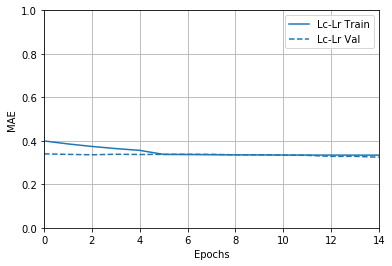

In [38]:
histories['Lc-Lr'] = early_history0

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 1])
plt.ylabel('MAE')

In [39]:
model1 = build_model(len(normed_train_data1.keys()),activ,learn)

early_history1 = model1.fit(normed_train_data1, train_labels1, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,val_labels1], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:3.0395,  mae:0.5051,  mse:3.0395,  val_loss:0.1440,  val_mae:0.2059,  val_mse:0.1440,  
..............................

Text(0, 0.5, 'MAE')

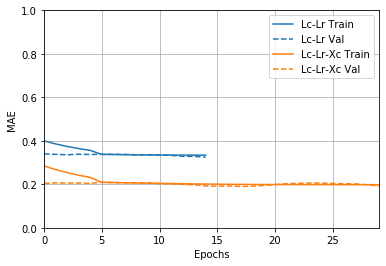

In [40]:
histories['Lc-Lr-Xc'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 1])
plt.ylabel('MAE')

In [41]:
model2 = build_model(len(normed_train_data2.keys()),activ,learn)

early_history2 = model2.fit(normed_train_data2, train_labels2, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,val_labels2], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:3.0301,  mae:0.4676,  mse:3.0301,  val_loss:0.1339,  val_mae:0.2010,  val_mse:0.1339,  
.............................................

Text(0, 0.5, 'MAE')

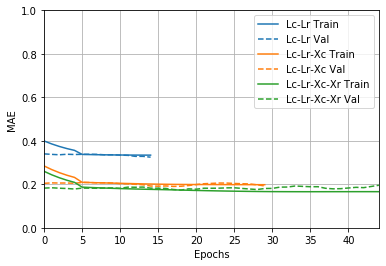

In [42]:
histories['Lc-Lr-Xc-Xr'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 1])
plt.ylabel('MAE')

In [43]:
model3 = build_model(len(normed_train_data3.keys()),activ,learn)

early_history3 = model3.fit(normed_train_data3, train_labels3, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,val_labels3], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:2.2016,  mae:0.4299,  mse:2.2016,  val_loss:0.1314,  val_mae:0.2011,  val_mse:0.1314,  
..............................

Text(0, 0.5, 'MAE')

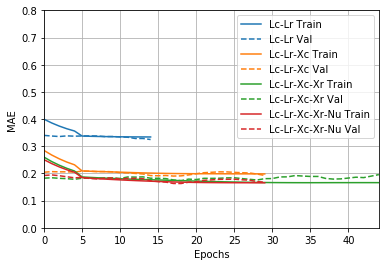

In [44]:
histories['Lc-Lr-Xc-Xr-nu'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 0.8])
plt.ylabel('MAE')

Text(0, 0.5, 'MSE')

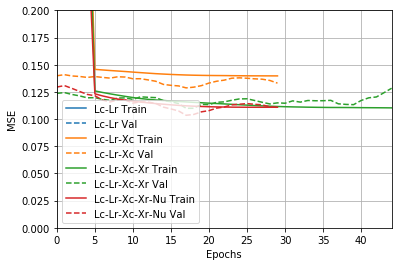

In [45]:
plotter.plot(histories, metric = "mse")
plt.ylim([0, 0.2])
plt.ylabel('MSE')

In [46]:
loss0, mae0, mse0 = model0.evaluate(normed_test_data0, test_labels0, verbose=2)

print("Testing set for model 0, Mean Abs Error: {:10.5f}".format(mae0))

185956/185956 - 4s - loss: 0.2071 - mae: 0.3078 - mse: 0.2071
Testing set for model 0, Mean Abs Error:    0.30780


In [47]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data1, test_labels1, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

185956/185956 - 4s - loss: 0.1071 - mae: 0.1821 - mse: 0.1071
Testing set for model 1, Mean Abs Error:    0.18214


In [48]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data2, test_labels2, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:10.5f}".format(mae2))

185956/185956 - 4s - loss: 0.1613 - mae: 0.2336 - mse: 0.1613
Testing set for model 2, Mean Abs Error:    0.23360


In [49]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data3, test_labels3, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:10.5f}".format(mae3))

185956/185956 - 4s - loss: 0.0942 - mae: 0.1813 - mse: 0.0942
Testing set for model 3, Mean Abs Error:    0.18132


# Save models and normalization

In [50]:
# Save the entire model as a SavedModel.

!mkdir -p saved_model_v9

model0.save('saved_model_v9/accretion_withN_01_LcLr_'+activ+'_16x16x16_'+data) 
model1.save('saved_model_v9/accretion_withN_01_LcLrXc_'+activ+'_16x16x16_'+data) 
model2.save('saved_model_v9/accretion_withN_01_LcLrXcXr_'+activ+'_16x16x16_'+data) 
model3.save('saved_model_v9/accretion_withN_01_LcLrXcXrNu_'+activ+'_16x16x16_'+data) 

# save train_stats for normalization of input data in Pandas pickle format
train_stats0.to_pickle('saved_model_v9/accretion_withN_01_LcLr_'+activ+'_16x16x16_'+data+'_norm.pickle')
train_stats1.to_pickle('saved_model_v9/accretion_withN_01_LcLrXc_'+activ+'_16x16x16_'+data+'_norm.pickle')
train_stats2.to_pickle('saved_model_v9/accretion_withN_01_LcLrXcXr_'+activ+'_16x16x16_'+data+'_norm.pickle')
train_stats3.to_pickle('saved_model_v9/accretion_withN_01_LcLrXcXrNu_'+activ+'_16x16x16_'+data+'_norm.pickle')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model_v9/accretion_withN_01_LcLr_ReLU_16x16x16_big_n5/assets
INFO:tensorflow:Assets written to: saved_model_v9/accretion_withN_01_LcLrXc_ReLU_16x16x16_big_n5/assets
INFO:tensorflow:Assets written to: saved_model_v9/accretion_withN_01_LcLrXcXr_ReLU_16x16x16_big_n5/assets
INFO:tensorflow:Assets written to: saved_model_v9/accretion_withN_01_LcLrXcXrNu_ReLU_16x16x16_big_n5/assets


In [51]:
model2.predict(normed_test_data2)

array([[-34.632256 ,  -7.8223004],
       [-34.324722 ,  -7.522797 ],
       [-34.058746 ,  -7.277362 ],
       ...,
       [-15.695917 ,   9.391921 ],
       [-15.845656 ,   9.248273 ],
       [-15.992776 ,   9.106731 ]], dtype=float32)

# Make predictions

Finally, predict the fall velocity values using data in the testing set:

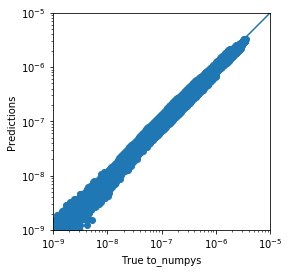

In [52]:
ptest_acc0 = np.exp(test_labels0).to_numpy()
ptest_acc1 = np.exp(test_labels1).to_numpy()
ptest_acc2 = np.exp(test_labels2).to_numpy()
ptest_acc3 = np.exp(test_labels3).to_numpy()
ptest_acc4 = np.exp(test_labels4).to_numpy()

test_acc0 = ptest_acc0[:,0]
test_acc1 = ptest_acc1[:,0]
test_acc2 = ptest_acc2[:,0]
test_acc3 = ptest_acc3[:,0]
test_acc4 = ptest_acc4[:,0]

predict0 = np.exp(model0.predict(normed_test_data0))
predict1 = np.exp(model1.predict(normed_test_data1))
predict2 = np.exp(model2.predict(normed_test_data2))

test_predict0  = predict0[:,0]
test_predict1  = predict1[:,0]
test_predict2  = predict2[:,0]
test_predict2N = predict2[:,1]

amin, amax = 1e-9, 1e-5

a = plt.axes(aspect='equal')
plt.scatter(test_acc2, test_predict2)
plt.xlabel('True to_numpys')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

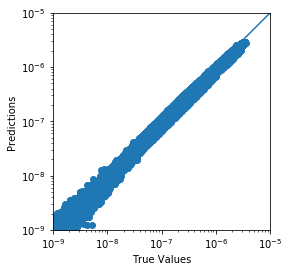

In [53]:
predict3 = np.exp(model3.predict(normed_test_data3))

test_predict3  = predict3[:,0]
test_predict3N = predict3[:,1]

a = plt.axes(aspect='equal')
plt.scatter(test_acc3, test_predict3)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Compare with SB2001 and KK2000

In [54]:
test_dataset4.describe()

Lc             Lr            tau
count  185956.000000  185956.000000  185956.000000
mean       -8.556026     -12.184974      -4.607143
std         1.502526       5.245859       5.233325
min       -12.718877     -29.615793     -22.840141
25%        -9.352686     -15.147145      -7.546070
50%        -8.113855     -10.181244      -2.582053
75%        -7.602155      -8.132809      -0.189211
max        -6.503471      -6.513580      -0.010051

In [55]:
qc  = np.exp(np.array(test_dataset4.Lc))
qr  = np.exp(np.array(test_dataset4.Lr))

tau2 = qr/(qc+qr)

## SB2001 autoconversion rate, original and re-trained on current data

In [56]:
kcr = 5.78      # Long kernel in m3 kg-1 s-1 

phi = (tau2 / (tau2 + 5e-4))**4

accSB = kcr * qc * qr * phi


In [57]:
test_acc4

array([1.20980225e-14, 1.44106122e-14, 1.37416052e-14, ...,
       1.55611062e-07, 1.34823964e-07, 1.15737961e-07], dtype=float32)

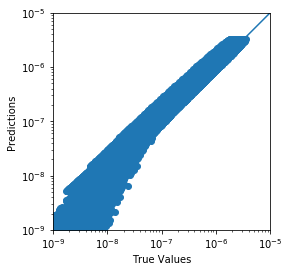

In [58]:
test_predict_sb = accSB

a = plt.axes(aspect='equal')
plt.scatter(test_acc4, test_predict_sb)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## Power law regression 

from notebook 'McSnow_autocon_powerlaws'

In [59]:
fac = 6.0
a = 1.1
b = 1.0
c = 0.1


# AU = fac * Lc**a * Nc**b * nu**c
accPwr = fac * np.power(qc,a) * np.power(qr,b) #* np.power(nu+1,c)  

In [60]:
np.mean(accPwr)

7.665037e-08

## KK2000 accretion

In [61]:

accKK = 67. * np.power(qc*qr,1.15) 

In [62]:
np.mean(accKK)

1.7511813e-07

## Final statistics 

In [63]:
acc0 = test_predict0
acc1 = test_predict1
acc2 = test_predict2
acc3 = test_predict3

accTruth = test_acc4

In [64]:
np.max(accTruth)

3.5058015e-06

In [65]:
def mean_abs_error(au, auTrue):  
    return np.mean(np.abs(au - auTrue))

def mean_sqr_error(au, auTrue):    
    return np.sqrt(np.mean((au - auTrue)**2))                   

In [66]:
mae0 = mean_abs_error(acc0,test_acc0)
mae1 = mean_abs_error(acc1,test_acc1)
mae2 = mean_abs_error(acc2,test_acc2)
mae3 = mean_abs_error(acc3,test_acc3)
maeSB = mean_abs_error(accSB,accTruth)
maeKK  = mean_abs_error(accKK,accTruth)
maePwr = mean_abs_error(accPwr,accTruth)

mse0 = mean_sqr_error(acc0,test_acc0)
mse1 = mean_sqr_error(acc1,test_acc1)
mse2 = mean_sqr_error(acc2,test_acc2)
mse3 = mean_sqr_error(acc3,test_acc3)
mseSB = mean_sqr_error(accSB,accTruth)
mseKK  = mean_sqr_error(accKK,accTruth)
msePwr = mean_sqr_error(accPwr,accTruth)

mae = [ mae0, mae1, mae2, mae3, maeSB, maeKK ] #, maeSB2, maeKK, maePwr ]
mse = [ mse0, mse1, mse2, mse3, mseSB, mseKK ] #, mseSB2, mseKK, msePwr ]

In [67]:
mae

[1.9220762e-08,
 1.4572252e-08,
 1.4526065e-08,
 1.7670928e-08,
 2.6155988e-08,
 4.125352e-08]

In [68]:
labels = list(histories.keys())
labels.append('SB2001')
labels.append('KK2000')
labels

['Lc-Lr', 'Lc-Lr-Xc', 'Lc-Lr-Xc-Xr', 'Lc-Lr-Xc-Xr-nu', 'SB2001', 'KK2000']

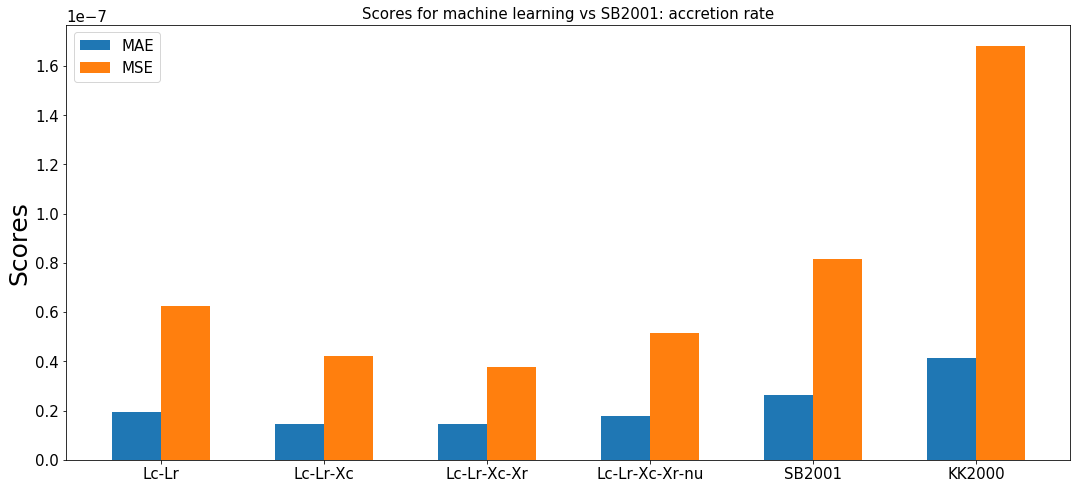

In [69]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size
#labels = [ 'Lc-Lr', 'Lc-Lr-Nc', 'Lc-Lr-Nr', 'Lc-Lr-Nc-Nr', 'Lc-Lr-Nc-Nr-nu', 'SB2001' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mae, width, label='MAE')
rects2 = ax.bar(x + width/2, mse, width, label='MSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores for machine learning vs SB2001: accretion rate')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#fig.tight_layout()

plt.show()



In [70]:
fig.savefig("accretion_barplot_withN_"+activ+"_"+data+"_eps15.png", bbox_inches='tight', dpi=600)